In [8]:
import pandas as pd
import pickle
from sklearn.feature_extraction.text import CountVectorizer


In [9]:
train_data=pd.read_csv('./data/bbc_news_train.txt', sep=',')
test_data=pd.read_csv('./data/bbc_news_tests.txt', sep=',')

train_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [10]:
train_data.shape

(1490, 3)

In [11]:
train_data.isna().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [12]:
test_data.isna().sum()

Unnamed: 0    0
ArticleId     0
Text          0
Category      0
dtype: int64

In [13]:
category_proportions = train_data['Category'].value_counts()
category_proportions

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

In [14]:
from preprocessing import preprocessing
train_data['Text']= [preprocessing(text) for text in train_data['Text'] ]
test_data['Text']= [preprocessing(text) for text in test_data['Text'] ]
train_data.head()

[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/student/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


,ArticleId,Text,Category
0,1833,worldcom ex boss launch defenc lawyer defend f...,business
1,154,german busi confid slide german busi confid fe...,business
2,1101,bbc poll indic econom gloom citizen major nati...,business
3,1976,lifestyl govern mobil choic faster better funk...,tech
4,917,enron boss payout eighteen former enron direct...,business


In [15]:
cv = CountVectorizer()

X_train = cv.fit_transform(train_data['Text'])
X_test= cv.transform(test_data['Text'])

with open("vectorizer.pkl", "wb") as vec_file:
    pickle.dump(cv, vec_file)

In [16]:
replacement = {'sport': 1, 'business': 2, 'politics': 3, 'entertainment': 4, 'tech': 5}

train_data['Category'] = train_data['Category'].apply(lambda x: replacement.get(x, 0))
test_data['Category'] = test_data['Category'].apply(lambda x: replacement.get(x, 0) )


y_train= train_data['Category']
y_test= test_data['Category']

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


clf = LogisticRegression(max_iter=10000, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(y_pred[:10])

report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)

# 3. Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


Accuracy: 0.9741
[1 5 1 2 1 1 3 3 4 2]

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       165
           2       0.95      0.97      0.96       174
           3       0.97      0.96      0.96       143
           4       0.96      0.98      0.97       113
           5       0.99      0.96      0.97       140

    accuracy                           0.97       735
   macro avg       0.97      0.97      0.97       735
weighted avg       0.97      0.97      0.97       735


Confusion Matrix:
 [[165   0   0   0   0]
 [  0 168   3   3   0]
 [  0   3 137   2   1]
 [  0   1   0 111   1]
 [  0   4   1   0 135]]


In [18]:
# Sauvegardez le modèle dans un fichier
with open('topic_classifier.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [19]:
# test load modele
#with open('topic_classifier.pkl', 'rb') as file:
#   model=pickle.load(file)
#   y_pred = model.predict(X_test)
#   accuracy = accuracy_score(y_test, y_pred)
#   print(f"Accuracy: {accuracy:.4f}")

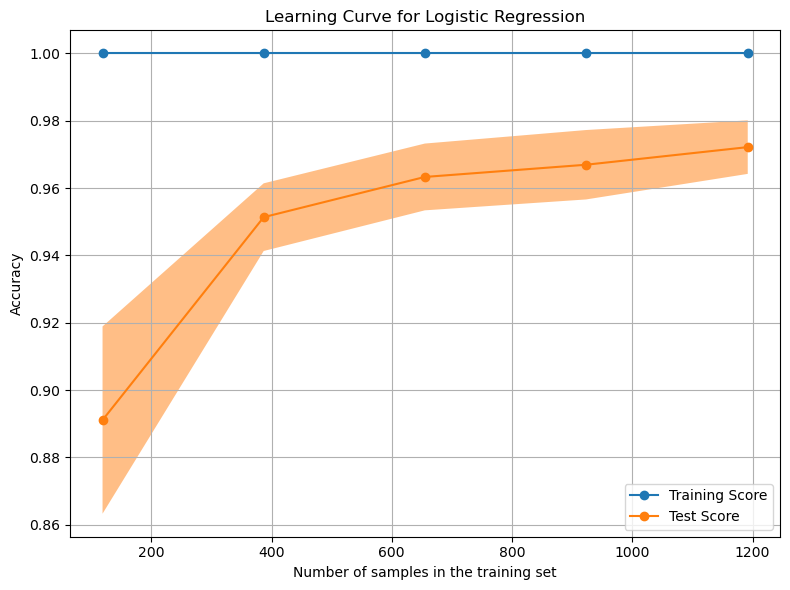

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit


common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),  
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),  
    "score_type": "both",  
    "n_jobs": -1,  
    "line_kw": {"marker": "o"},  
    "std_display_style": "fill_between",  
    "score_name": "Accuracy",  
}


fig, ax = plt.subplots(figsize=(8, 6))

LearningCurveDisplay.from_estimator(clf, **common_params, ax=ax)

handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title("Learning Curve for Logistic Regression")
plt.grid(True)
plt.tight_layout()
plt.show()

fig.savefig('learning_curves.png')
